In [1]:
# Please uncomment the specific library to be installed if needed.
# !pip install contractions
# !pip install gensim
# !pip install pyldavis
# !pip install wordcloud 

import pandas as pd
from sklearn.preprocessing import LabelEncoder
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import re
from bs4 import BeautifulSoup
import unicodedata
import contractions
import nltk
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk import bigrams
from nltk import trigrams
from collections import Counter
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import TruncatedSVD
import gensim
from gensim.models import Word2Vec
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis

In [2]:
suicidal_reddit = pd.read_csv('si_reddit.csv')
suicidal_twitter = pd.read_csv('si_twitter.csv')
suicidal_twitter2 = pd.read_csv('si_twitter2.csv')

In [3]:
suicidal_reddit.info()
suicidal_twitter.info()
suicidal_twitter2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 232074 entries, 0 to 232073
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   Unnamed: 0  232074 non-null  int64 
 1   text        232074 non-null  object
 2   class       232074 non-null  object
dtypes: int64(1), object(2)
memory usage: 5.3+ MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1787 entries, 0 to 1786
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   Tweet    1785 non-null   object
 1   Suicide  1787 non-null   object
dtypes: object(2)
memory usage: 28.1+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9119 entries, 0 to 9118
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   tweet      9119 non-null   object
 1   intention  9119 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 142.6+ KB


suicidal_reddit : The column 'Unnamed: 0' need to be evaluated. <br>
suicidal_twitter: There are 2 null values in column 'Tweet'. <br>
suicidal_twitter2: Both column names of twitter dataset need to standardise.

In [4]:
suicidal_reddit.head(5)

,Unnamed: 0,text,class
0,2,Ex Wife Threatening SuicideRecently I left my ...,suicide
1,3,Am I weird I don't get affected by compliments...,non-suicide
2,4,Finally 2020 is almost over... So I can never ...,non-suicide
3,8,i need helpjust help me im crying so hard,suicide
4,9,"I’m so lostHello, my name is Adam (16) and I’v...",suicide


In [5]:
suicidal_reddit.drop({'Unnamed: 0'}, axis=1, inplace=True)
suicidal_reddit.head(5)

,text,class
0,Ex Wife Threatening SuicideRecently I left my ...,suicide
1,Am I weird I don't get affected by compliments...,non-suicide
2,Finally 2020 is almost over... So I can never ...,non-suicide
3,i need helpjust help me im crying so hard,suicide
4,"I’m so lostHello, my name is Adam (16) and I’v...",suicide


In [6]:
null_twitter = suicidal_twitter.isnull().any(axis=1)
null_rows = suicidal_twitter[null_twitter]

print(null_rows)

     Tweet                  Suicide
497    NaN  Potential Suicide post 
1017   NaN         Not Suicide post


In [7]:
suicidal_twitter.dropna(how='any', inplace=True)
suicidal_twitter.isnull().sum()

Tweet      0
Suicide    0
dtype: int64

In [8]:
suicidal_twitter2 = suicidal_twitter2.rename(columns={'tweet': 'Tweet', 'intention': 'Suicide'})

In [9]:
print(suicidal_twitter['Suicide'].value_counts())
print(suicidal_twitter2['Suicide'].value_counts())

Suicide
Not Suicide post           1126
Potential Suicide post      659
Name: count, dtype: int64
Suicide
0    5121
1    3998
Name: count, dtype: int64


In [10]:
label_encoder = LabelEncoder()
suicidal_twitter['Suicide'] = label_encoder.fit_transform(suicidal_twitter['Suicide'])
suicidal_twitter2['Suicide'] = label_encoder.fit_transform(suicidal_twitter2['Suicide'])

In [11]:
print(suicidal_twitter['Suicide'].value_counts())
print(suicidal_twitter2['Suicide'].value_counts())

Suicide
0    1126
1     659
Name: count, dtype: int64
Suicide
0    5121
1    3998
Name: count, dtype: int64


In [12]:
suicidal_twitter = pd.concat([suicidal_twitter, suicidal_twitter2], axis=0)

In [13]:
suicidal_twitter['Suicide'].value_counts()

Suicide
0    6247
1    4657
Name: count, dtype: int64

In [14]:
suicidal_reddit['class'].value_counts()

class
suicide        116037
non-suicide    116037
Name: count, dtype: int64

In [15]:
value_counts_suicidal_reddit = pd.DataFrame(suicidal_reddit['class'].value_counts())
value_counts_suicidal_reddit = value_counts_suicidal_reddit.reset_index()
value_counts_suicidal_reddit.columns = ['class', 'count']
print(value_counts_suicidal_reddit)

         class   count
0      suicide  116037
1  non-suicide  116037


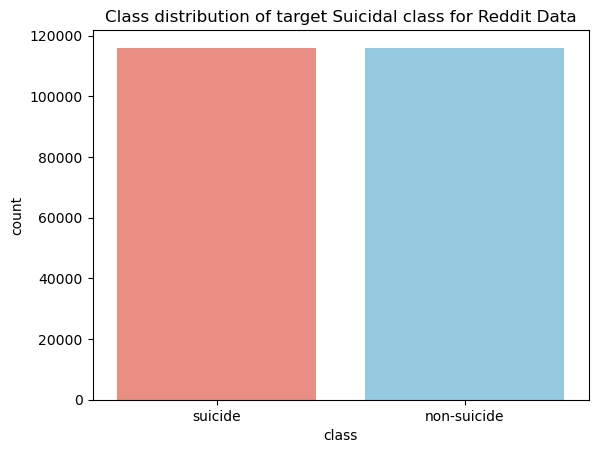

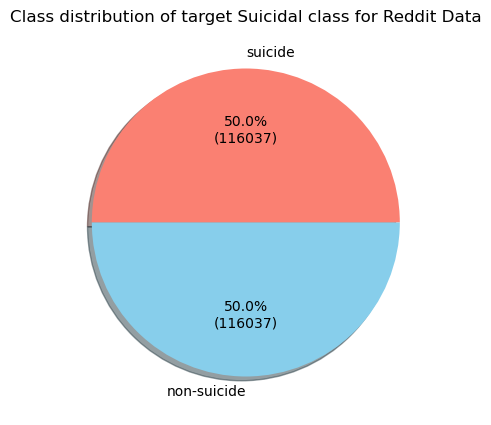

In [16]:
sns.barplot(data=value_counts_suicidal_reddit, x='class', y='count', palette=['salmon', 'skyblue'])
plt.title('Class distribution of target Suicidal class for Reddit Data')
plt.show()

def autopct_format(values):
        def my_format(pct):
            total = sum(values)
            val = int(round(pct*total/100.0))
            return '{:.1f}%\n({v:d})'.format(pct, v=val)
        return my_format

plt.figure(figsize=(5, 5))
plt.pie(value_counts_suicidal_reddit['count'], labels=value_counts_suicidal_reddit['class'], autopct=autopct_format(value_counts_suicidal_reddit['count']), colors=['salmon', 'skyblue'], shadow=True)
plt.title('Class distribution of target Suicidal class for Reddit Data')
plt.show()

In [17]:
value_counts_suicidal_twitter = pd.DataFrame(suicidal_twitter['Suicide'].value_counts())
value_counts_suicidal_twitter = value_counts_suicidal_twitter.reset_index()
value_counts_suicidal_twitter.columns = ['class', 'count']
print(value_counts_suicidal_twitter)

   class  count
0      0   6247
1      1   4657


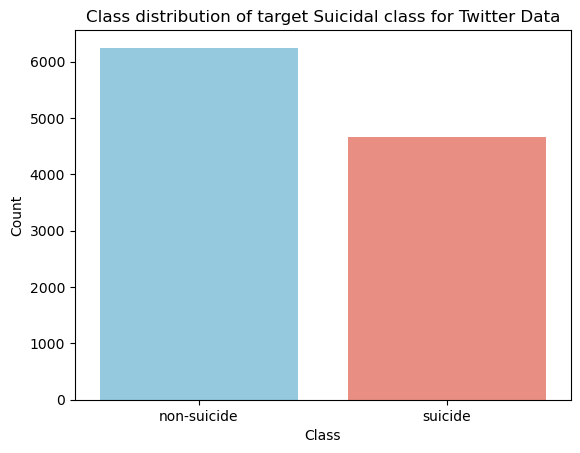

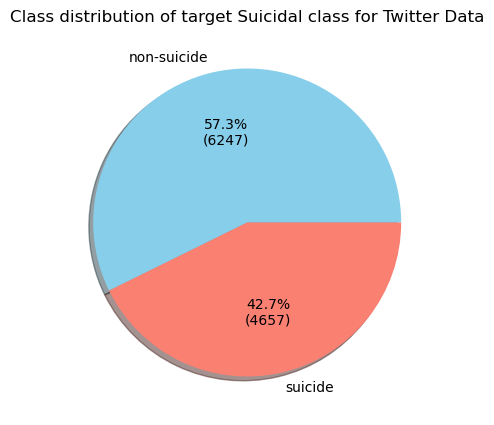

In [18]:
sns.barplot(value_counts_suicidal_twitter, x='class', y='count',palette=['skyblue','salmon'])
plt.title('Class distribution of target Suicidal class for Twitter Data')
plt.xticks([0, 1], ['non-suicide', 'suicide'])
plt.xlabel('Class')
plt.ylabel('Count')
plt.show()

def autopct_format(values):
        def my_format(pct):
            total = sum(values)
            val = int(round(pct*total/100.0))
            return '{:.1f}%\n({v:d})'.format(pct, v=val)
        return my_format

def map_class_to_label(class_value):
    if class_value == 0:
        return 'non-suicide'
    elif class_value == 1:
        return 'suicide'
    else:
        return 'unknown'
    
plt.figure(figsize=(5, 5))
plt.pie(value_counts_suicidal_twitter['count'], labels=[map_class_to_label(class_val) for class_val in value_counts_suicidal_twitter['class']], autopct=autopct_format(value_counts_suicidal_twitter['count']), colors=['skyblue', 'salmon'], shadow=True)
plt.title('Class distribution of target Suicidal class for Twitter Data')
plt.show()

Based on the visualization of the data distribution above, it can be concluded that the twitter data is imbalanced. There are most frequent non-suiicidal messages than the suicidal messages in twitter dataset.

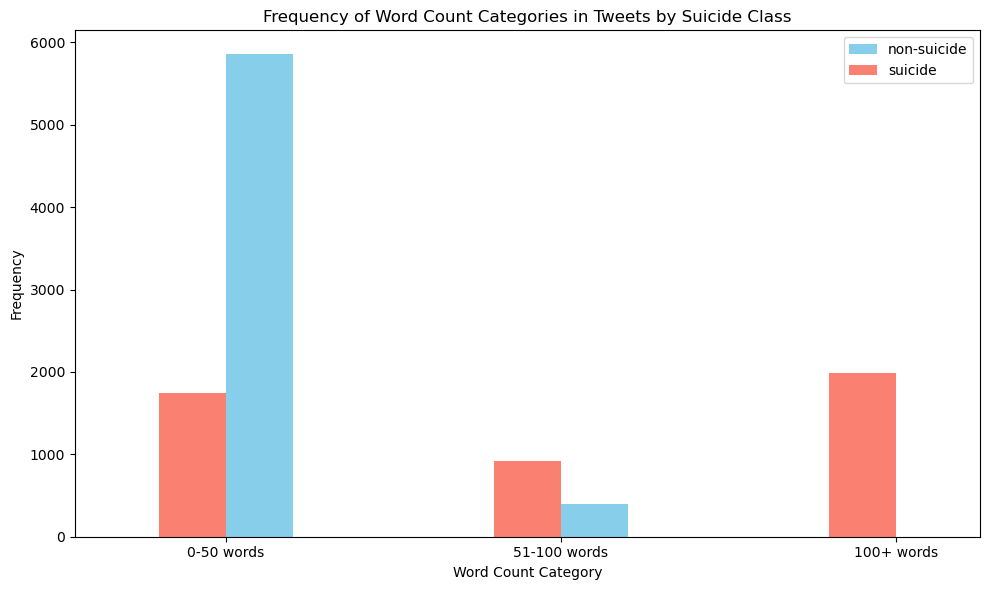

In [19]:
# Calculate word length for each tweet
df1 = suicidal_twitter.copy()
df1['Word Length'] = df1['Tweet'].astype(str).apply(lambda text: len(re.sub(' {2,}', ' ', text).split(' '))).values

# Define custom word count categories
bins = [0, 50, 100, float('inf')]
categories = ['0-50 words', '51-100 words', '100+ words']

# Categorize word lengths into custom bins
df1['Word Count Category'] = pd.cut(df1['Word Length'], bins=bins, labels=categories, right=False)

# Group by word count category and 'Suicide', calculate frequency
word_count_freq = df1.groupby(['Word Count Category', 'Suicide']).size().unstack(fill_value=0)

# Plotting
fig, ax = plt.subplots(figsize=(10, 6))

# Plot for Suicide = 0
word_count_freq[0].plot(kind='bar', position=0, color='skyblue', width=0.2, label='non-suicide', ax=ax)

# Plot for Suicide = 1
word_count_freq[1].plot(kind='bar', position=1, color='salmon', width=0.2, label='suicide', ax=ax)

# Set labels and title
ax.set_xlabel('Word Count Category')
ax.set_ylabel('Frequency')
ax.set_title('Frequency of Word Count Categories in Tweets by Suicide Class')

# Set x-axis tick labels
plt.xticks(rotation=0)

# Add legend
plt.legend()

plt.tight_layout()
plt.show()

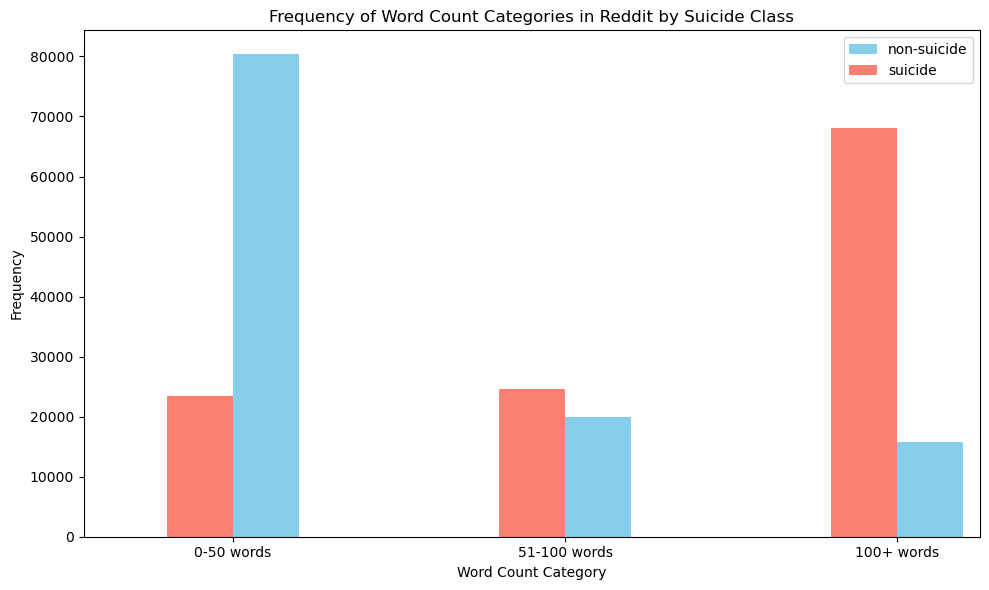

In [20]:
# Calculate word length for each tweet
df2 = suicidal_reddit.copy()
df2['Word Length'] = df2['text'].astype(str).apply(lambda text: len(re.sub(' {2,}', ' ', text).split(' '))).values

# Define custom word count categories
bins = [0, 50, 100, float('inf')]
categories = ['0-50 words', '51-100 words', '100+ words']

# Categorize word lengths into custom bins
df2['Word Count Category'] = pd.cut(df2['Word Length'], bins=bins, labels=categories, right=False)

# Group by word count category and 'class', calculate frequency
word_count_freq = df2.groupby(['Word Count Category', 'class']).size().unstack(fill_value=0)

# Plotting
fig, ax = plt.subplots(figsize=(10, 6))

# Plot for Non-suicide
word_count_freq['non-suicide'].plot(kind='bar', position=0, color='skyblue', width=0.2, label='non-suicide', ax=ax)

# Plot for Suicide
word_count_freq['suicide'].plot(kind='bar', position=1, color='salmon', width=0.2, label='suicide', ax=ax)

# Set labels and title
ax.set_xlabel('Word Count Category')
ax.set_ylabel('Frequency')
ax.set_title('Frequency of Word Count Categories in Reddit by Suicide Class')

# Set x-axis tick labels
plt.xticks(rotation=0)

# Add legend
plt.legend()

plt.tight_layout()
plt.show()

In [21]:
df1.head(5)

,Tweet,Suicide,Word Length,Word Count Category
0,making some lunch,0,3,0-50 words
1,@Alexia You want his money.,0,5,0-50 words
2,@dizzyhrvy that crap took me forever to put to...,1,16,0-50 words
3,@jnaylor #kiwitweets Hey Jer! Since when did y...,0,10,0-50 words
4,Trying out &quot;Delicious Library 2&quot; wit...,0,26,0-50 words


In [22]:
df2.head(5)

,text,class,Word Length,Word Count Category
0,Ex Wife Threatening SuicideRecently I left my ...,suicide,143,100+ words
1,Am I weird I don't get affected by compliments...,non-suicide,27,0-50 words
2,Finally 2020 is almost over... So I can never ...,non-suicide,26,0-50 words
3,i need helpjust help me im crying so hard,suicide,9,0-50 words
4,"I’m so lostHello, my name is Adam (16) and I’v...",suicide,435,100+ words


## Data Pre-processing
-----
1. [Case Standardisation](#lower)
2. [Accent Characters Standardisation](#accent)
3. [Remove Emails](#emails)
4. [Remove HTML Tags](#html)
5. [Remove Website Links and Image URL](#url)
6. [Remove Mentions and Hashtags](#hashtags)
7. [Remove Newline Characters](#newline)
8. [Expand Contractions](#expand)
9. [Remove Special Characters](#special)
10. [Remove Punctuation](#punctuation)
11. [Remove Digits](#digits)
12. [Remove Extra White Spaces](#space)
13. [Remove Stopwords](#stopwords)

Sources: 
- https://gauravtanwar1.medium.com/nlp-a-comprehensive-guide-to-text-cleaning-and-preprocessing-63f364febfc5
- https://medium.com/@priyankads/common-regular-expressions-for-text-cleaning-in-python-5a13b832d340

In [23]:
suicidal_reddit.isna().sum()

text     0
class    0
dtype: int64

In [24]:
suicidal_twitter.isna().sum()

Tweet      0
Suicide    0
dtype: int64

### Case Standardisation
<a id='lower'></a>
Turning text into lower case - .lower()

In [25]:
suicidal_twitter['Tweet'] = suicidal_twitter['Tweet'].astype(str)

In [26]:
def to_lowercase(textfile):
    return textfile.lower()

In [27]:
samplerowwithuppercase = suicidal_reddit.iloc[8]['text']
samplerowwithuppercase

'Everyone wants to be "edgy" and it\'s making me self conscious I feel like I don\'t stand out. I can draw yes and play the guitar but I honestly feel like am stuck in the past, my taste in music are all rock and alt metal from\n2000\'s to the 90\'s and it doesn\'t really make me feel unique it\'s just my style but seeing as my friends and classmates getting more into rap and EDM it\'s hard for me to feel like I fit in.\nThe I don\'t feel like I stand out is because of all the others copying a style and if I do that I\'d be just another\n"Quirky kid" who\'s in a cringey phase.\nMany of my friends say that I look good in grunge style and I kinda agree but it\'s hard for me to continue that if I can\'t even stand out from all the "edgy\nPeople who wore crosses and wallet chains and do tiktoks"\n\nReally feels like I don\'t fit in in all categories, am scared that people might confuse me with a CLOUT CHASER or a fucking tiktok e boy goddamn\nI hate my life'

In [28]:
suicidal_reddit['text'] = suicidal_reddit['text'].apply(to_lowercase)

In [29]:
samplerowwithuppercase = suicidal_reddit.iloc[8]['text']
samplerowwithuppercase

'everyone wants to be "edgy" and it\'s making me self conscious i feel like i don\'t stand out. i can draw yes and play the guitar but i honestly feel like am stuck in the past, my taste in music are all rock and alt metal from\n2000\'s to the 90\'s and it doesn\'t really make me feel unique it\'s just my style but seeing as my friends and classmates getting more into rap and edm it\'s hard for me to feel like i fit in.\nthe i don\'t feel like i stand out is because of all the others copying a style and if i do that i\'d be just another\n"quirky kid" who\'s in a cringey phase.\nmany of my friends say that i look good in grunge style and i kinda agree but it\'s hard for me to continue that if i can\'t even stand out from all the "edgy\npeople who wore crosses and wallet chains and do tiktoks"\n\nreally feels like i don\'t fit in in all categories, am scared that people might confuse me with a clout chaser or a fucking tiktok e boy goddamn\ni hate my life'

In [30]:
suicidal_twitter['Tweet'] = suicidal_twitter['Tweet'].apply(to_lowercase)

### Accent Characters Standardisation
<a id='accent'></a>
Removing non-ASCII characters due to accent characters.

In [31]:
def standardize_accented_chars(textfile):
 return unicodedata.normalize('NFKD', textfile).encode('ascii', 'ignore').decode('utf-8', 'ignore')

In [32]:
rowwithstandardize_accented_chars = suicidal_twitter.iloc[1760]['Tweet']
rowwithstandardize_accented_chars

'i hate going into my rap zone cause then i think to myself damn people should really hear this but then i go oh welâ\x80¦ https://t.co/qu72v284yt'

In [33]:
suicidal_twitter['Tweet'] = suicidal_twitter['Tweet'].apply(standardize_accented_chars)

In [34]:
rowwithstandardize_accented_chars = suicidal_twitter.iloc[1760]['Tweet']
rowwithstandardize_accented_chars

'i hate going into my rap zone cause then i think to myself damn people should really hear this but then i go oh wela https://t.co/qu72v284yt'

In [35]:
suicidal_reddit['text'] = suicidal_reddit['text'].apply(standardize_accented_chars)

### Remove Emails
<a id='emails'></a>
Removing emails ("([\w\.\-\_]+@[\w\.\-\_]+)") <br>
Email addresses can be written in different forms. Therefore, the square brackets function as or operator and hence characters, full-stops, hyphen, underscore are allowed before and after the @.

In [36]:
# def remove_emails(textfile):
#     return re.sub("([\w\.\-\_]+@[\w\.\-\_]+)", '', textfile)
 
def remove_emails(textfile):
    return re.sub("([\\w\\.\\-\\_]+@[\\w\\.\\-\\_]+)", '', textfile)

In [37]:
sampleemail = suicidal_reddit.iloc[2764]['text']
sampleemail

'seeking a pen pal to navigate the stormsi am sure many can relate with me; i am really struggling with being honest to those closet to me about just how low i am. i am looking for some escapism and a friend. i want to be a friend to you and carry each other through the storms. because the sun always comes out again. maybe not today but someday soon. take care poppets. it may get choppy. \nonegingernutjob@gmail.com'

In [38]:
suicidal_reddit['text'] = suicidal_reddit['text'].apply(remove_emails)

In [39]:
sampleemail = suicidal_reddit.iloc[2764]['text']
sampleemail

'seeking a pen pal to navigate the stormsi am sure many can relate with me; i am really struggling with being honest to those closet to me about just how low i am. i am looking for some escapism and a friend. i want to be a friend to you and carry each other through the storms. because the sun always comes out again. maybe not today but someday soon. take care poppets. it may get choppy. \n'

In [40]:
suicidal_twitter['Tweet'] = suicidal_twitter['Tweet'].apply(remove_emails)

### Remove HTML Tags
<a id='html'></a>
Removing html_tags ('<.*?'). The BeautifulSoup library is apply for removing HTML tags.

In [41]:
def remove_html_tags(text):
    return BeautifulSoup(text, 'html.parser').get_text()

In [42]:
suicidal_reddit['text'] = suicidal_reddit['text'].apply(remove_html_tags)

/var/folders/sq/m0w5clln2hjfkdxp60p78cg00000gn/T/ipykernel_20843/3642797177.py:2: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  return BeautifulSoup(text, 'html.parser').get_text()


In [43]:
suicidal_twitter['Tweet'] = suicidal_twitter['Tweet'].apply(remove_html_tags)

/var/folders/sq/m0w5clln2hjfkdxp60p78cg00000gn/T/ipykernel_20843/3642797177.py:2: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  return BeautifulSoup(text, 'html.parser').get_text()


### Remove Website Links and Image URL
<a id='url'></a>
Removing website links and image URL ('http\S+|www\S+|https\S+').

In [44]:
def remove_url(textfile):
    return re.sub(r'http\S+|www\S+|https\S+','', textfile)

In [45]:
samplerowwithurl = suicidal_reddit.iloc[109]['text']
samplerowwithurl

'check out this new horror short i made https://youtu.be/s50mcngm1ws it took me a while to make so hope you enjoy it'

In [46]:
suicidal_reddit['text'] = suicidal_reddit['text'].apply(remove_url)

In [47]:
samplerowwithurl = suicidal_reddit.iloc[109]['text']
samplerowwithurl

'check out this new horror short i made  it took me a while to make so hope you enjoy it'

In [48]:
suicidal_twitter['Tweet'] = suicidal_twitter['Tweet'].apply(remove_url)

### Remove Mentions and Hashtags
<a id='hashtags'></a>
Removing @username and hashtags ('\@\w+|\#') or ('#\S*') for Twitter dataset and mentions and hashtags ('@\S*') for reddit data.

In [49]:
def remove_username_tags(textfile):
    return re.sub(r'@\S*', '', textfile)

def remove_username_hashtags(textfile):
    textfile = re.sub(r'@\S*', '', textfile)
    return re.sub(r'#\S*', '', textfile)

In [50]:
tags = suicidal_twitter.iloc[95]['Tweet']
tags

"@kateedwards you dont have to bring anything - it's yr place #katesparty"

In [51]:
suicidal_twitter['Tweet'] = suicidal_twitter['Tweet'].apply(remove_username_hashtags)

In [52]:
tags = suicidal_twitter.iloc[95]['Tweet']
tags

" you dont have to bring anything - it's yr place "

In [53]:
suicidal_reddit['text'] = suicidal_reddit['text'].apply(remove_username_tags)

### Remove Newline Characters
<a id='newline'></a>
Removing newline characters ('\n')

In [54]:
def remove_newlines(textfile):
    return re.sub(r'\n', ' ', textfile)

In [55]:
newlines = suicidal_reddit.iloc[2939]['text']
newlines

"it's not enough to just be fat and lonely, but now i have to be diagnosed with oral cancer. fuck.while all of my close friends are comfy with their girlfriends and fiancees, i'm just sitting here kicking it until i die. i don't necessarily want to die, but the fact that i just got diagnosed with cancer really doesn't help.\n\nnothing turned out the way i wanted it to. i was supposed to graduate college, get a good job and have some girl fall in love with me. instead, i dropped out because of crippling depression after my grandfather (my father figure) died, got scrap jobs for the last five years and now....well, now...i have fucking cancer.\n\nif there is a god, this is him giving me the stone cold stunner. i'm down for the count. if i do survive, my life won't even be worth it. instead, i'd love to just try and start again. it doesn't happen this way, but fuck. it makes me sick that some of the people i know that don't deserve shit are taking trips to fucking cabo three times a year 

In [56]:
suicidal_reddit['text'] = suicidal_reddit['text'].apply(remove_newlines)
suicidal_twitter['Tweet'] = suicidal_twitter['Tweet'].apply(remove_newlines)

In [57]:
newlines = suicidal_reddit.iloc[2939]['text']
newlines

"it's not enough to just be fat and lonely, but now i have to be diagnosed with oral cancer. fuck.while all of my close friends are comfy with their girlfriends and fiancees, i'm just sitting here kicking it until i die. i don't necessarily want to die, but the fact that i just got diagnosed with cancer really doesn't help.  nothing turned out the way i wanted it to. i was supposed to graduate college, get a good job and have some girl fall in love with me. instead, i dropped out because of crippling depression after my grandfather (my father figure) died, got scrap jobs for the last five years and now....well, now...i have fucking cancer.  if there is a god, this is him giving me the stone cold stunner. i'm down for the count. if i do survive, my life won't even be worth it. instead, i'd love to just try and start again. it doesn't happen this way, but fuck. it makes me sick that some of the people i know that don't deserve shit are taking trips to fucking cabo three times a year and 

### Expand Contractions
<a id='expand'></a>
Expand contractions to convert eg: i'll  to I will.

In [58]:
#Expand contractions
def expand_contractions(textfile):
    expanded_words = []
    for word in textfile.split():
       expanded_words.append(contractions.fix(word))
    return ' '.join(expanded_words)

In [59]:
suicidal_reddit['text'] = suicidal_reddit['text'].apply(expand_contractions)
suicidal_twitter['Tweet'] = suicidal_twitter['Tweet'].apply(expand_contractions)

In [60]:
expandcontractions = suicidal_reddit.iloc[2939]['text']
expandcontractions

'it is not enough to just be fat and lonely, but now i have to be diagnosed with oral cancer. fuck.while all of my close friends are comfy with their girlfriends and fiancees, i am just sitting here kicking it until i die. i do not necessarily want to die, but the fact that i just got diagnosed with cancer really does not help. nothing turned out the way i wanted it to. i was supposed to graduate college, get a good job and have some girl fall in love with me. instead, i dropped out because of crippling depression after my grandfather (my father figure) died, got scrap jobs for the last five years and now....well, now...i have fucking cancer. if there is a god, this is him giving me the stone cold stunner. i am down for the count. if i do survive, my life will not even be worth it. instead, i would love to just try and start again. it does not happen this way, but fuck. it makes me sick that some of the people i know that do not deserve shit are taking trips to fucking cabo three times

### Remove Special Characters
<a id='special'></a>
Removing special characters like %,$,&, and etc.

In [61]:
def remove_special_characters(textfile):
   return re.sub(r'[^a-zA-z0-9.,!?/:;\"\'\s]', '', textfile)

In [62]:
suicidal_reddit['text'] = suicidal_reddit['text'].apply(remove_special_characters)
suicidal_twitter['Tweet'] = suicidal_twitter['Tweet'].apply(remove_special_characters)

In [63]:
specialcharacters = suicidal_reddit.iloc[2939]['text']
specialcharacters

'it is not enough to just be fat and lonely, but now i have to be diagnosed with oral cancer. fuck.while all of my close friends are comfy with their girlfriends and fiancees, i am just sitting here kicking it until i die. i do not necessarily want to die, but the fact that i just got diagnosed with cancer really does not help. nothing turned out the way i wanted it to. i was supposed to graduate college, get a good job and have some girl fall in love with me. instead, i dropped out because of crippling depression after my grandfather my father figure died, got scrap jobs for the last five years and now....well, now...i have fucking cancer. if there is a god, this is him giving me the stone cold stunner. i am down for the count. if i do survive, my life will not even be worth it. instead, i would love to just try and start again. it does not happen this way, but fuck. it makes me sick that some of the people i know that do not deserve shit are taking trips to fucking cabo three times a

### Remove Punctuation
<a id='punctuation'></a>
Removing punctuation ('!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~')

In [64]:
def remove_punctuations(textfile):
    return re.sub(r"[!\"#$%&()*+-./:;<=>?@[\]^_`{|}~\n -' ]", " ", textfile)

In [65]:
suicidal_reddit['text'] = suicidal_reddit['text'].apply(remove_punctuations)
suicidal_twitter['Tweet'] = suicidal_twitter['Tweet'].apply(remove_punctuations)

In [66]:
punctations = suicidal_reddit.iloc[2939]['text']
punctations

'it is not enough to just be fat and lonely  but now i have to be diagnosed with oral cancer  fuck while all of my close friends are comfy with their girlfriends and fiancees  i am just sitting here kicking it until i die  i do not necessarily want to die  but the fact that i just got diagnosed with cancer really does not help  nothing turned out the way i wanted it to  i was supposed to graduate college  get a good job and have some girl fall in love with me  instead  i dropped out because of crippling depression after my grandfather my father figure died  got scrap jobs for the last five years and now    well  now   i have fucking cancer  if there is a god  this is him giving me the stone cold stunner  i am down for the count  if i do survive  my life will not even be worth it  instead  i would love to just try and start again  it does not happen this way  but fuck  it makes me sick that some of the people i know that do not deserve shit are taking trips to fucking cabo three times a

### Remove Digits
<a id='digits'></a>
Removing digits ('[^a-zA-z.,!?/:;\"\'\s]')

In [67]:
#removing digits
def remove_digits(textfile):
    return re.sub(r'[^a-zA-z.,!?/:;\"\'\s]','', textfile)

In [68]:
suicidal_twitter['Tweet'] = suicidal_twitter['Tweet'].apply(remove_digits)
suicidal_reddit['text'] = suicidal_reddit['text'].apply(remove_digits)

In [69]:
withoutdigits = suicidal_reddit.iloc[2939]['text']
withoutdigits

'it is not enough to just be fat and lonely  but now i have to be diagnosed with oral cancer  fuck while all of my close friends are comfy with their girlfriends and fiancees  i am just sitting here kicking it until i die  i do not necessarily want to die  but the fact that i just got diagnosed with cancer really does not help  nothing turned out the way i wanted it to  i was supposed to graduate college  get a good job and have some girl fall in love with me  instead  i dropped out because of crippling depression after my grandfather my father figure died  got scrap jobs for the last five years and now    well  now   i have fucking cancer  if there is a god  this is him giving me the stone cold stunner  i am down for the count  if i do survive  my life will not even be worth it  instead  i would love to just try and start again  it does not happen this way  but fuck  it makes me sick that some of the people i know that do not deserve shit are taking trips to fucking cabo three times a

### Remove Extra White Spaces
<a id='space'></a>

In [70]:
def remove_space(textfile):
    return re.sub(r'\s+',' ', textfile)

In [71]:
suicidal_reddit['text'] = suicidal_reddit['text'].apply(remove_space)
suicidal_twitter['Tweet'] = suicidal_twitter['Tweet'].apply(remove_space)

In [72]:
extraspaces = suicidal_reddit.iloc[2939]['text']
extraspaces

'it is not enough to just be fat and lonely but now i have to be diagnosed with oral cancer fuck while all of my close friends are comfy with their girlfriends and fiancees i am just sitting here kicking it until i die i do not necessarily want to die but the fact that i just got diagnosed with cancer really does not help nothing turned out the way i wanted it to i was supposed to graduate college get a good job and have some girl fall in love with me instead i dropped out because of crippling depression after my grandfather my father figure died got scrap jobs for the last five years and now well now i have fucking cancer if there is a god this is him giving me the stone cold stunner i am down for the count if i do survive my life will not even be worth it instead i would love to just try and start again it does not happen this way but fuck it makes me sick that some of the people i know that do not deserve shit are taking trips to fucking cabo three times a year and i am scrapping fo

### Remove Stopwords
<a id='stopwords'></a>
Stopwords like I, am, me, etc, don’t add any information that can help in modeling. Eliminating stopwords can improve the accuracy and relevance of NLP tasks by drawing attention to the more important words, or content words.

In [73]:
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /Users/lxy/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /Users/lxy/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [74]:
stop_words = set(stopwords.words('english'))

ps = PorterStemmer()

def token_stem(text_file):
    words = word_tokenize(text_file)
    stemmed_words = [ps.stem(word) for word in words if word.lower() not in stop_words]
    stemmed_text = ' '.join(stemmed_words)
    return stemmed_text

In [75]:
suicidal_twitter['Tweet'] = suicidal_twitter['Tweet'].apply(token_stem)
suicidal_twitter

,Tweet,Suicide
0,make lunch,0
1,want money,0
2,crap took forev put togeth iam go go sleep day,1
3,hey jer sinc start twitter,0
4,tri delici librari mix result bar code thought...,0
...,...,...
9114,ever laid bed night cri good enough count flaw...,1
9115,fault blame pain still alon insid broken home ...,1
9116,stop ask trust still cough water last time let...,1
9117,never know handl sad cri make feel stupid,1


In [76]:
suicidal_reddit['text'] = suicidal_reddit['text'].apply(token_stem)
suicidal_reddit

,text,class
0,ex wife threaten suiciderec left wife good che...,suicide
1,weird get affect compliment come someon know i...,non-suicide
2,final almost never hear bad year ever swear fu...,non-suicide
3,need helpjust help cri hard,suicide
4,losthello name adam struggl year afraid past y...,suicide
...,...,...
232069,like rock go get anyth go,non-suicide
232070,tell mani friend lone everyth depriv prebought...,non-suicide
232071,pee probabl tast like salti tea someon drank p...,non-suicide
232072,usual stuff find herei post sympathi piti know...,suicide


<div class="alert alert-block alert-warning">
<b>After Data Pre-processing:</b> The cleaned data for reddit dataset and twitter dataset are save in csv file accordingly.
</div>

In [78]:
suicidal_reddit.to_csv('reddit_cleaned_stemmed_xy.csv')

In [79]:
suicidal_twitter.to_csv('twitter_cleaned_stemmed_xy.csv')

## EDA
------
1. Word Cloud
2. Text Statistics
3. Frequency Analysis
4. Part-of-Speech Tagging
5. Word Embeddings

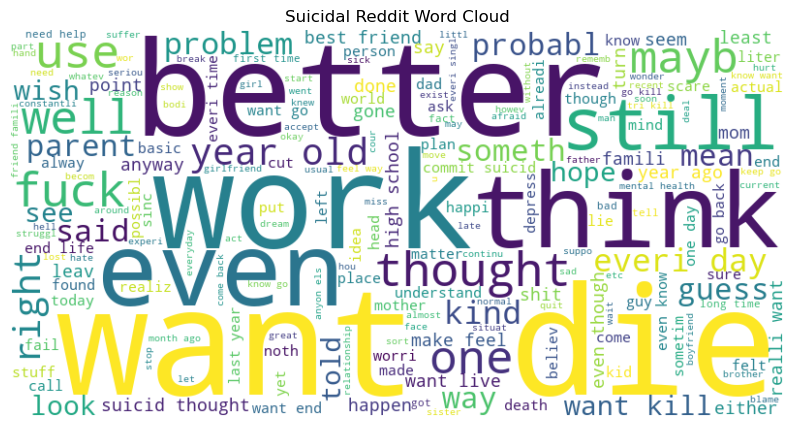

In [9]:
suicide_text = suicidal_reddit[suicidal_reddit['class'] == 'suicide']['text']
reddit_text_data = ' '.join(suicide_text.astype(str))

reddit_wordcloud = WordCloud(width=800, height=400, background_color='white').generate(reddit_text_data)
plt.figure(figsize=(10, 6))
plt.imshow(reddit_wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Suicidal Reddit Word Cloud')
plt.show()

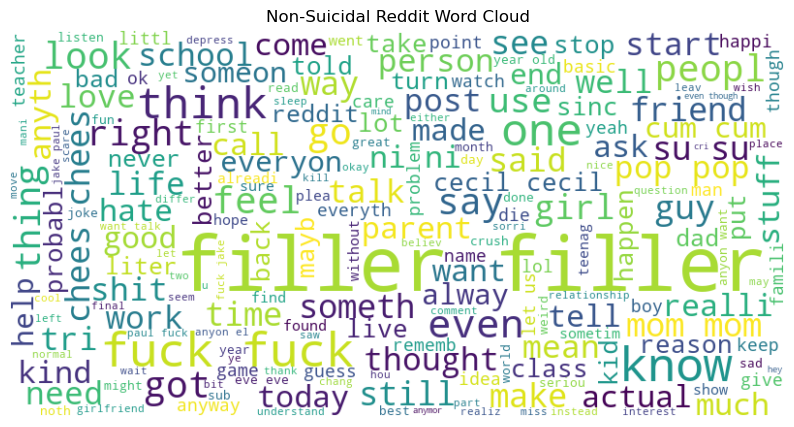

In [96]:
non_suicide_text = suicidal_reddit[suicidal_reddit['class'] == 'non-suicide']['text']
non_suicide_reddit_text_data = ' '.join(non_suicide_text.astype(str))

non_suicide_reddit_wordcloud = WordCloud(width=800, height=400, background_color='white').generate(non_suicide_reddit_text_data)
plt.figure(figsize=(10, 6))
plt.imshow(non_suicide_reddit_wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Non-Suicidal Reddit Word Cloud')
plt.show()

In [77]:
def get_top_ngram(corpus, n=None):
    vec = CountVectorizer(ngram_range=(n, n)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0)
    words_freq = [(word, sum_words[0, idx])
                  for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:10]

In [78]:
suicidal_reddit_text = suicidal_reddit.loc[suicidal_reddit['class'] == 'suicide', 'text']
suicidal_twitter_text = suicidal_twitter.loc[suicidal_twitter['Suicide'] == 1, 'Tweet']

Text(0.5, 1.0, 'Top 10 Bigrams in Suicidal Reddit')

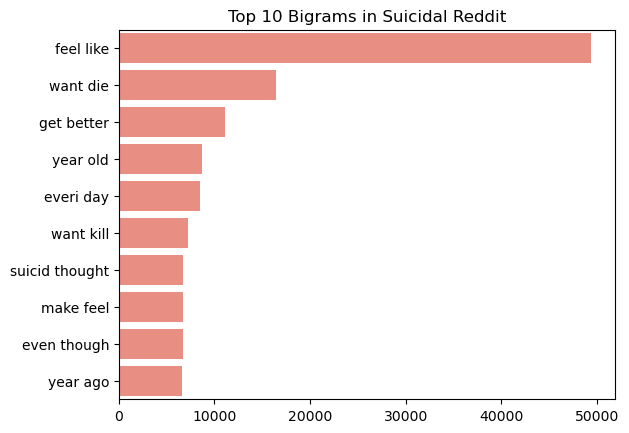

In [88]:
top_bi_grams=get_top_ngram(suicidal_reddit_text,n=2)
x,y=map(list,zip(*top_bi_grams))
sns.barplot(x=y,y=x,color="salmon").set_title('Top 10 Bigrams in Suicidal Reddit')

Text(0.5, 1.0, 'Top 10 Trigrams in Suicidal Reddit')

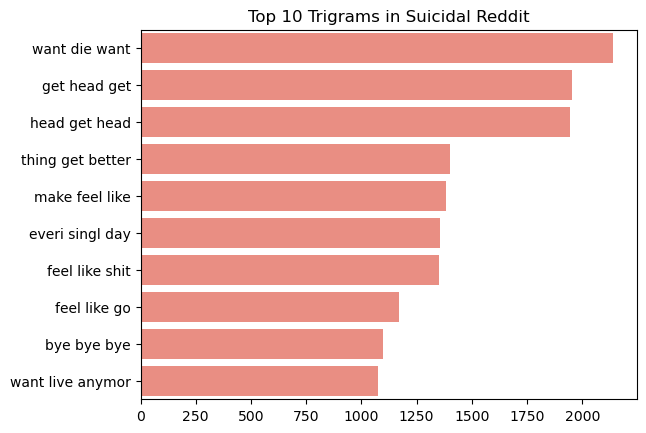

In [89]:
top_tri_grams=get_top_ngram(suicidal_reddit_text,n=3)
x,y=map(list,zip(*top_tri_grams))
sns.barplot(x=y,y=x,color="salmon").set_title('Top 10 Trigrams in Suicidal Reddit')

Text(0.5, 1.0, 'Top 10 Bigrams in Suicidal Twitter')

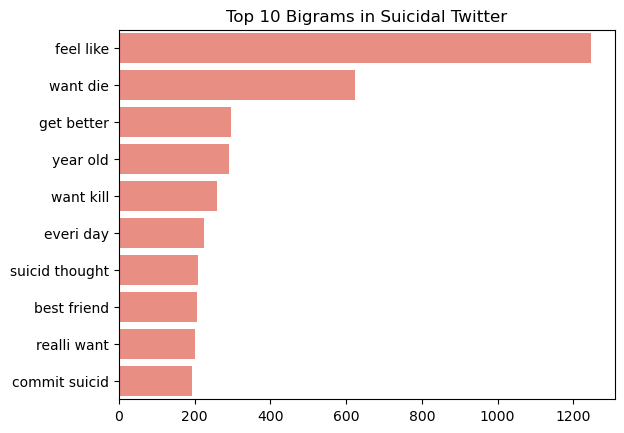

In [90]:
twitter_top_bi_grams=get_top_ngram(suicidal_twitter_text,n=2)
a,b=map(list,zip(*twitter_top_bi_grams))
sns.barplot(x=b,y=a,color="salmon").set_title('Top 10 Bigrams in Suicidal Twitter')

Text(0.5, 1.0, 'Top 10 Trigrams in Suicidal Twitter')

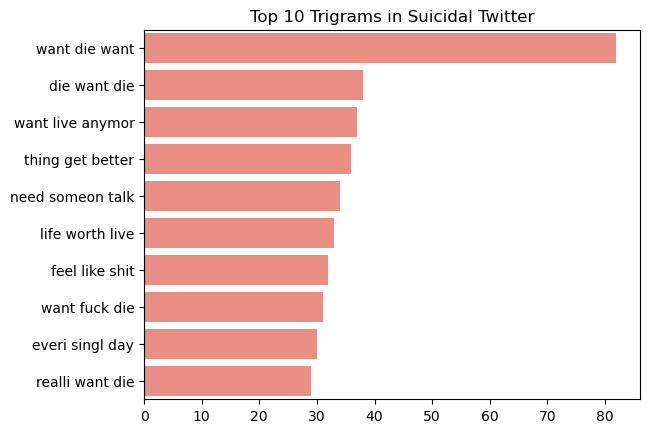

In [91]:
twitter_top_tri_grams=get_top_ngram(suicidal_twitter_text,n=3)
a,b=map(list,zip(*twitter_top_tri_grams))
sns.barplot(x=b,y=a,color="salmon").set_title('Top 10 Trigrams in Suicidal Twitter')

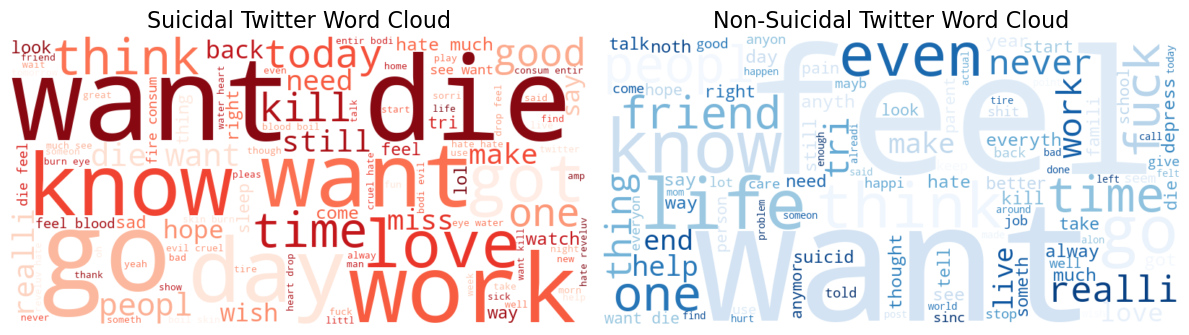

In [77]:
# Separate texts based on labels
twitter_suicide_texts = ' '.join(suicidal_twitter[suicidal_twitter['Suicide'] == 0]['Tweet'].astype(str))
twitter_non_suicide_texts = ' '.join(suicidal_twitter[suicidal_twitter['Suicide'] == 1]['Tweet'].astype(str))

# Generate word clouds
twitter_wordcloud = WordCloud(width=800, height=400, background_color='white',
                              colormap='Reds', max_words=100, contour_width=3,
                              contour_color='firebrick').generate(twitter_suicide_texts)
non_suicide_twitter_wordcloud = WordCloud(width=800, height=400, background_color='white',
                                  colormap='Blues', max_words=100, contour_width=3,
                                  contour_color='navy').generate(twitter_non_suicide_texts)

# Plot word clouds
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.imshow(twitter_wordcloud, interpolation='bilinear')
plt.title('Suicidal Twitter Word Cloud', fontsize=16)
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(non_suicide_twitter_wordcloud, interpolation='bilinear')
plt.title('Non-Suicidal Twitter Word Cloud', fontsize=16)
plt.axis('off')

plt.tight_layout()
plt.show()

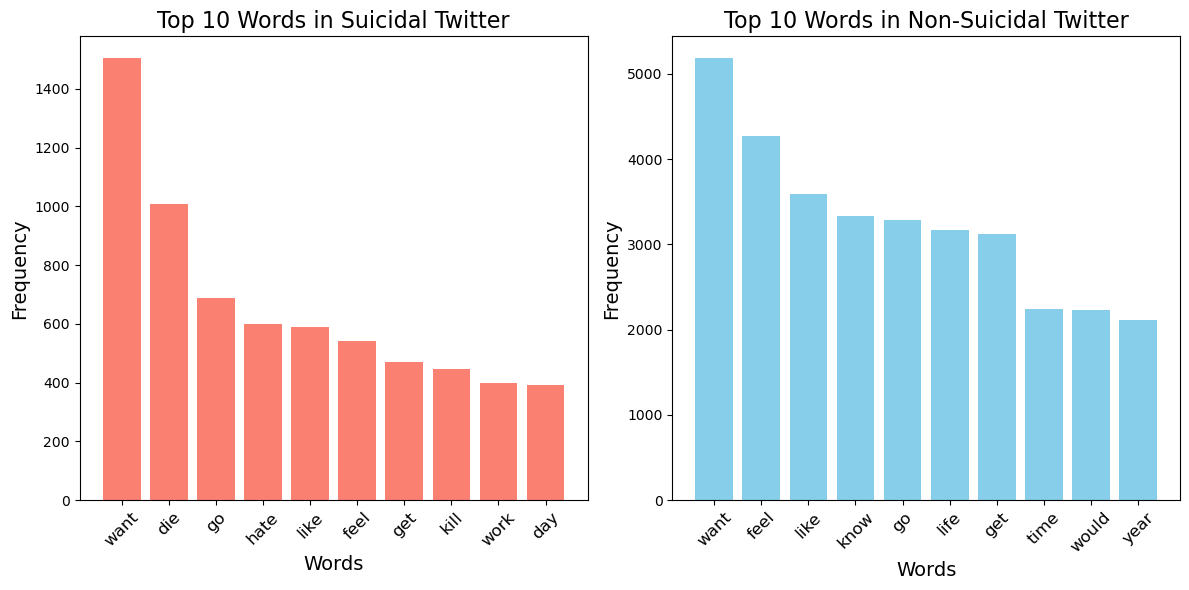

In [78]:
# Tokenize the texts
suicide_tokens = word_tokenize(twitter_suicide_texts)
non_suicide_tokens = word_tokenize(twitter_non_suicide_texts)

# Count word frequencies
suicide_word_freq = Counter(suicide_tokens)
non_suicide_word_freq = Counter(non_suicide_tokens)

# Plot the frequency of words in each category using bar charts
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.bar(*zip(*suicide_word_freq.most_common(10)), color='salmon')
plt.title('Top 10 Words in Suicidal Twitter', fontsize=16)
plt.xlabel('Words', fontsize=14)
plt.xticks(rotation=45, fontsize=12)
plt.ylabel('Frequency', fontsize=14)

plt.subplot(1, 2, 2)
plt.bar(*zip(*non_suicide_word_freq.most_common(10)), color='skyblue')
plt.title('Top 10 Words in Non-Suicidal Twitter', fontsize=16)
plt.xlabel('Words', fontsize=14)
plt.xticks(rotation=45, fontsize=12)
plt.ylabel('Frequency', fontsize=14)

plt.tight_layout()
plt.show()

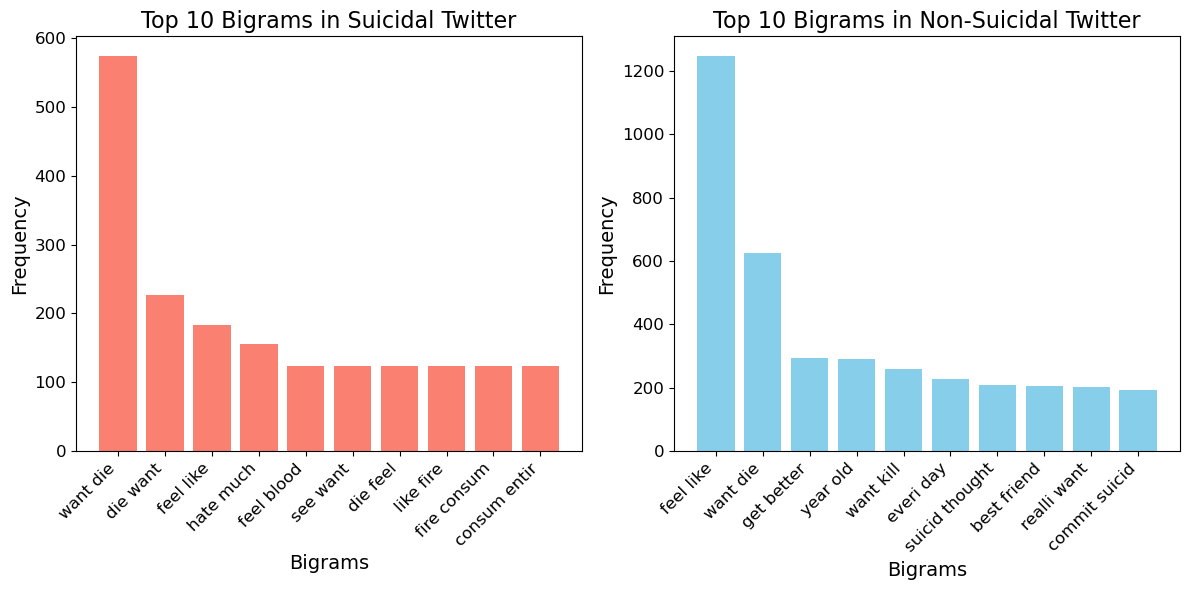

In [79]:
# Generate bigrams
suicide_bigrams = list(bigrams(suicide_tokens))
non_suicide_bigrams = list(bigrams(non_suicide_tokens))

# Count the occurrences of each bigram
suicide_bigram_freq = Counter(suicide_bigrams)
non_suicide_bigram_freq = Counter(non_suicide_bigrams)

# Get the most common bigrams
top_suicide_bigrams = suicide_bigram_freq.most_common(10)
top_non_suicide_bigrams = non_suicide_bigram_freq.most_common(10)

# Plot the most common bigrams for suicide texts
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.bar(*zip(*[(f"{bigram[0]} {bigram[1]}", count) for bigram, count in top_suicide_bigrams]), color='salmon')
plt.title('Top 10 Bigrams in Suicidal Twitter', fontsize=16)
plt.xlabel('Bigrams', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.xticks(rotation=45, ha='right', fontsize=12)
plt.yticks(fontsize=12)

# Plot the most common bigrams for non-suicide texts
plt.subplot(1, 2, 2)
plt.bar(*zip(*[(f"{bigram[0]} {bigram[1]}", count) for bigram, count in top_non_suicide_bigrams]), color='skyblue')
plt.title('Top 10 Bigrams in Non-Suicidal Twitter', fontsize=16)
plt.xlabel('Bigrams', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.xticks(rotation=45, ha='right', fontsize=12)
plt.yticks(fontsize=12)

plt.tight_layout()
plt.show()


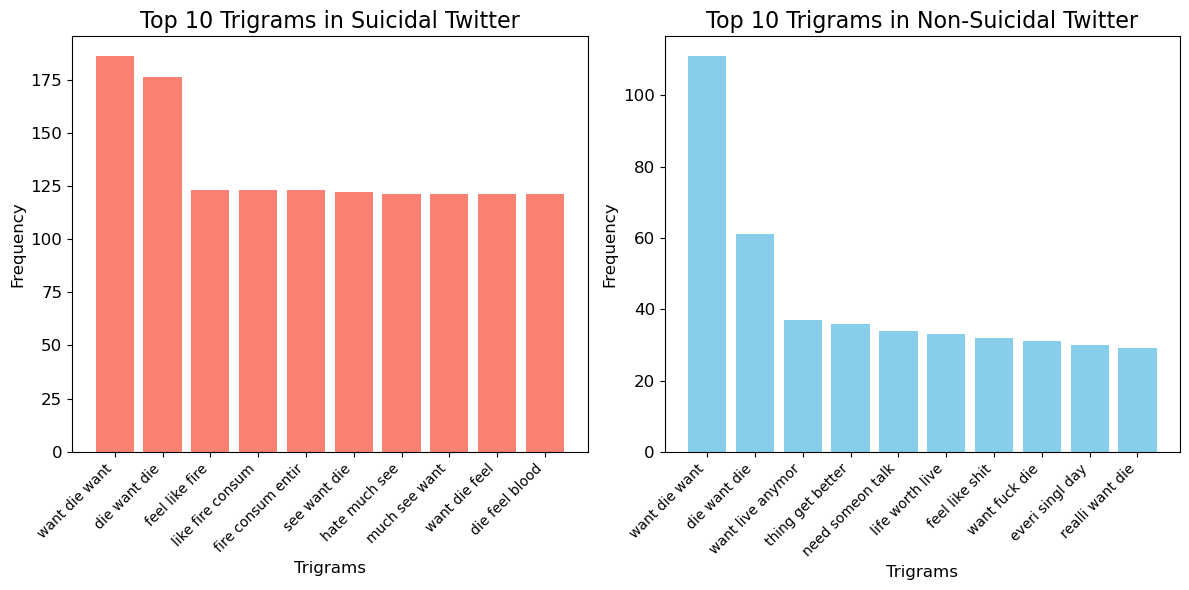

In [80]:
# Generate trigrams
suicide_trigrams = list(trigrams(suicide_tokens))
non_suicide_trigrams = list(trigrams(non_suicide_tokens))

# Count the occurrences of each trigram
suicide_trigram_freq = Counter(suicide_trigrams)
non_suicide_trigram_freq = Counter(non_suicide_trigrams)

# Get the most common trigrams
top_suicide_trigrams = suicide_trigram_freq.most_common(10)
top_non_suicide_trigrams = non_suicide_trigram_freq.most_common(10)

# Plot the most common trigrams for suicide texts
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.bar(*zip(*[(f"{trigram[0]} {trigram[1]} {trigram[2]}", count) for trigram, count in top_suicide_trigrams]), color='salmon')
plt.title('Top 10 Trigrams in Suicidal Twitter', fontsize=16)
plt.xlabel('Trigrams', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.yticks(fontsize=12)

# Plot the most common trigrams for non-suicide texts
plt.subplot(1, 2, 2)
plt.bar(*zip(*[(f"{trigram[0]} {trigram[1]} {trigram[2]}", count) for trigram, count in top_non_suicide_trigrams]), color='skyblue')
plt.title('Top 10 Trigrams in Non-Suicidal Twitter', fontsize=16)
plt.xlabel('Trigrams', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.yticks(fontsize=12)

plt.tight_layout()
plt.show()


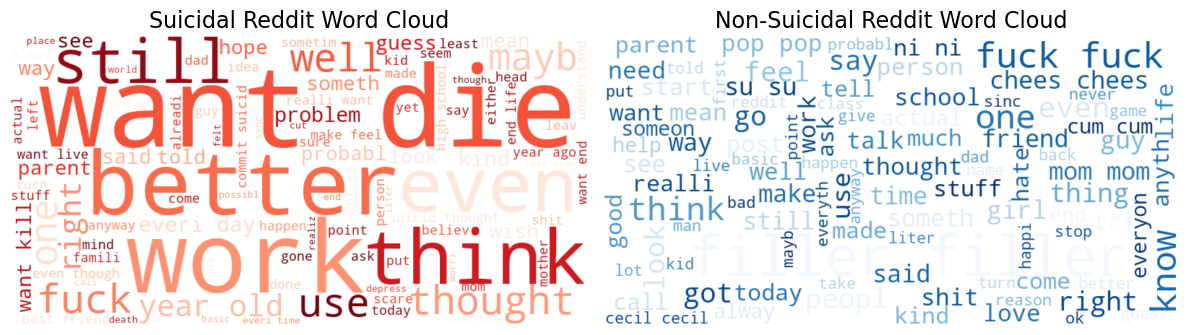

In [81]:
# Separate texts based on labels
reddit_suicide_texts = ' '.join(suicidal_reddit[suicidal_reddit['class'] == 'suicide']['text'].astype(str))
reddit_non_suicide_texts = ' '.join(suicidal_reddit[suicidal_reddit['class'] == 'non-suicide']['text'].astype(str))

# Generate word clouds
reddit_wordcloud = WordCloud(width=800, height=400, background_color='white',
                              colormap='Reds', max_words=100, contour_width=3,
                              contour_color='firebrick').generate(reddit_suicide_texts)
non_suicide_reddit_wordcloud = WordCloud(width=800, height=400, background_color='white',
                                  colormap='Blues', max_words=100, contour_width=3,
                                  contour_color='navy').generate(reddit_non_suicide_texts)

# Plot word clouds
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.imshow(reddit_wordcloud, interpolation='bilinear')
plt.title('Suicidal Reddit Word Cloud', fontsize=16)
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(non_suicide_reddit_wordcloud, interpolation='bilinear')
plt.title('Non-Suicidal Reddit Word Cloud', fontsize=16)
plt.axis('off')

plt.tight_layout()
plt.show()

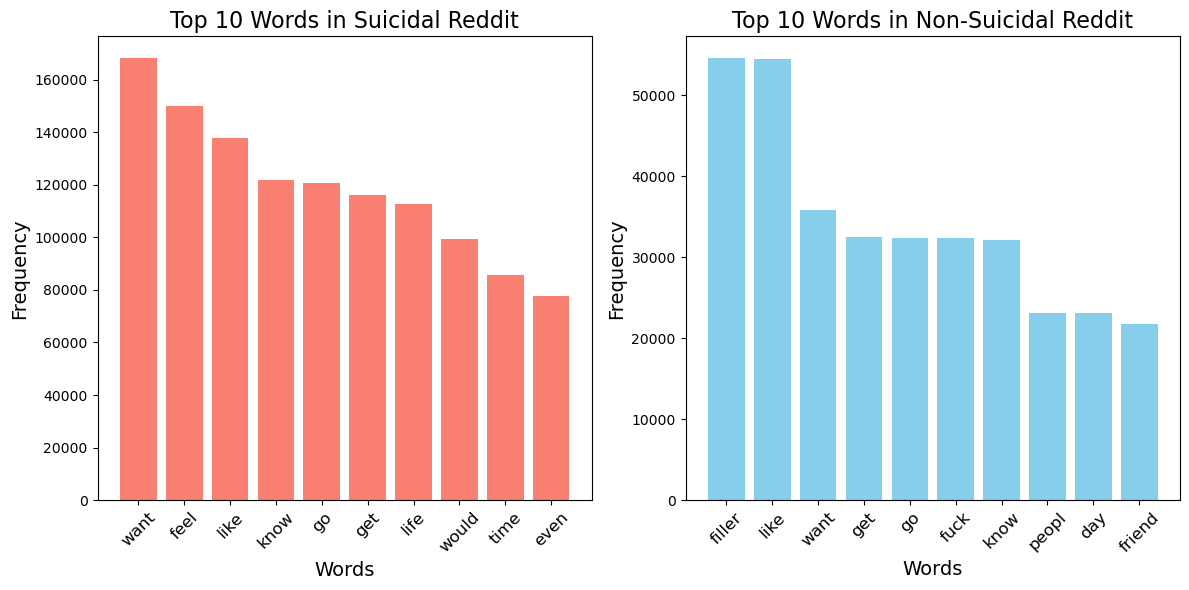

In [82]:
# Tokenize the texts
suicide_tokens = word_tokenize(reddit_suicide_texts)
non_suicide_tokens = word_tokenize(reddit_non_suicide_texts)

# Count word frequencies
suicide_word_freq = Counter(suicide_tokens)
non_suicide_word_freq = Counter(non_suicide_tokens)

# Plot the frequency of words in each category using bar charts
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.bar(*zip(*suicide_word_freq.most_common(10)), color='salmon')
plt.title('Top 10 Words in Suicidal Reddit', fontsize=16)
plt.xlabel('Words', fontsize=14)
plt.xticks(rotation=45, fontsize=12)
plt.ylabel('Frequency', fontsize=14)

plt.subplot(1, 2, 2)
plt.bar(*zip(*non_suicide_word_freq.most_common(10)), color='skyblue')
plt.title('Top 10 Words in Non-Suicidal Reddit', fontsize=16)
plt.xlabel('Words', fontsize=14)
plt.xticks(rotation=45, fontsize=12)
plt.ylabel('Frequency', fontsize=14)

plt.tight_layout()
plt.show()

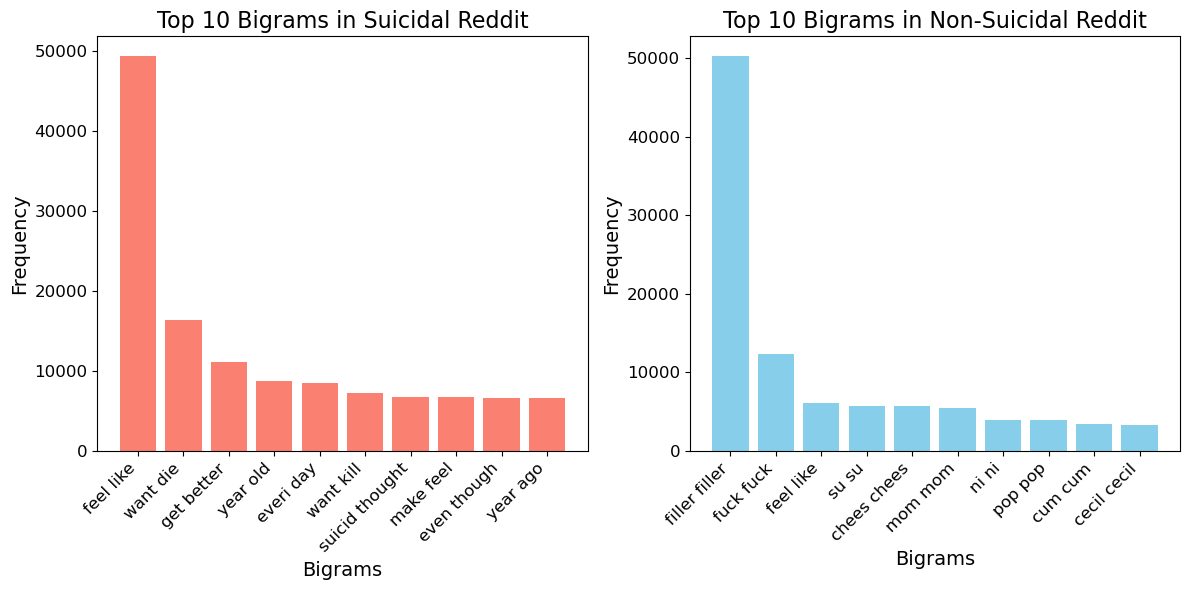

In [83]:
# Generate bigrams
suicide_bigrams = list(bigrams(suicide_tokens))
non_suicide_bigrams = list(bigrams(non_suicide_tokens))

# Count the occurrences of each bigram
suicide_bigram_freq = Counter(suicide_bigrams)
non_suicide_bigram_freq = Counter(non_suicide_bigrams)

# Get the most common bigrams
top_suicide_bigrams = suicide_bigram_freq.most_common(10)
top_non_suicide_bigrams = non_suicide_bigram_freq.most_common(10)

# Plot the most common bigrams for suicide texts
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.bar(*zip(*[(f"{bigram[0]} {bigram[1]}", count) for bigram, count in top_suicide_bigrams]), color='salmon')
plt.title('Top 10 Bigrams in Suicidal Reddit', fontsize=16)
plt.xlabel('Bigrams', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.xticks(rotation=45, ha='right', fontsize=12)
plt.yticks(fontsize=12)

# Plot the most common bigrams for non-suicide texts
plt.subplot(1, 2, 2)
plt.bar(*zip(*[(f"{bigram[0]} {bigram[1]}", count) for bigram, count in top_non_suicide_bigrams]), color='skyblue')
plt.title('Top 10 Bigrams in Non-Suicidal Reddit', fontsize=16)
plt.xlabel('Bigrams', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.xticks(rotation=45, ha='right', fontsize=12)
plt.yticks(fontsize=12)

plt.tight_layout()
plt.show()


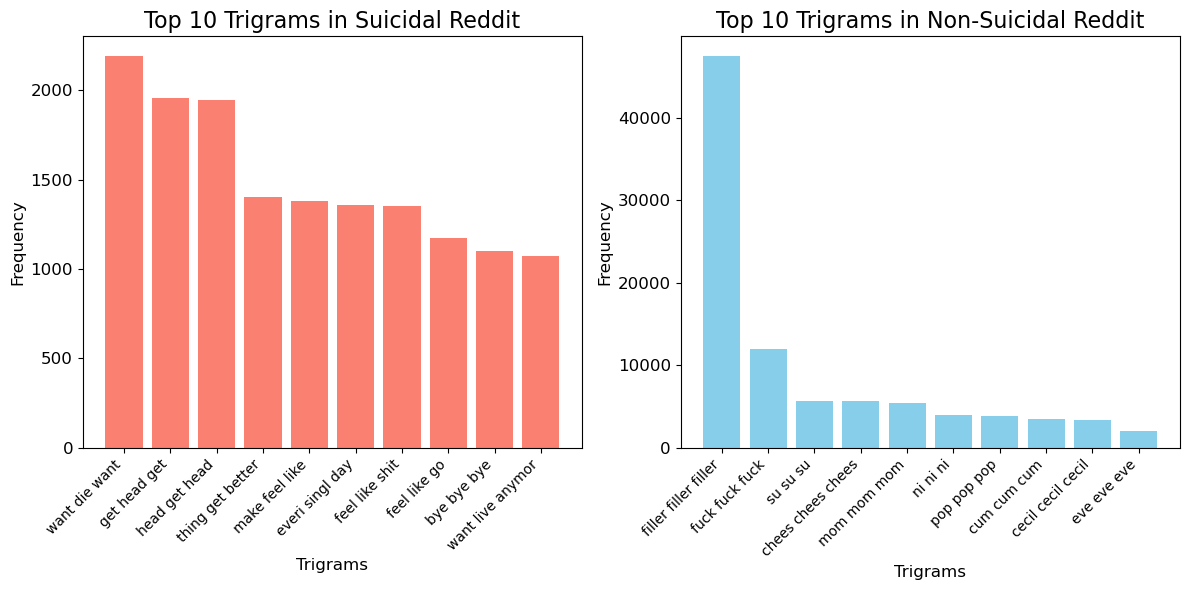

In [84]:
# Generate trigrams
suicide_trigrams = list(trigrams(suicide_tokens))
non_suicide_trigrams = list(trigrams(non_suicide_tokens))

# Count the occurrences of each trigram
suicide_trigram_freq = Counter(suicide_trigrams)
non_suicide_trigram_freq = Counter(non_suicide_trigrams)

# Get the most common trigrams
top_suicide_trigrams = suicide_trigram_freq.most_common(10)
top_non_suicide_trigrams = non_suicide_trigram_freq.most_common(10)

# Plot the most common trigrams for suicide texts
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.bar(*zip(*[(f"{trigram[0]} {trigram[1]} {trigram[2]}", count) for trigram, count in top_suicide_trigrams]), color='salmon')
plt.title('Top 10 Trigrams in Suicidal Reddit', fontsize=16)
plt.xlabel('Trigrams', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.yticks(fontsize=12)

# Plot the most common trigrams for non-suicide texts
plt.subplot(1, 2, 2)
plt.bar(*zip(*[(f"{trigram[0]} {trigram[1]} {trigram[2]}", count) for trigram, count in top_non_suicide_trigrams]), color='skyblue')
plt.title('Top 10 Trigrams in Non-Suicidal Reddit', fontsize=16)
plt.xlabel('Trigrams', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.yticks(fontsize=12)

plt.tight_layout()
plt.show()


### Topic modeling

Topic Modelling is a part of Machine Learning where the automated model analyzes the text data and creates the clusters of the words from that dataset or a set of documents. This is unsupervised learning, it works on automatically groups words without a predefined list of labels and find out the hidden patterns between words relates to those topics.

LDA works on the matrix factorization technique in which it assumes a is a mixture of topics and it backtracks to figure what topics would have created these documents. pyLDAvis will used to visualise the clusters created by LDA.

pyLDAvis is an open-source python library that allows us to interpret the topics in a topic model by creating highly interactive visualization of the clusters created by LDA. If feed the model data, it will give different sets of words, and each set of words describes the topic.

Ref: https://neptune.ai/blog/pyldavis-topic-modelling-exploration-tool-that-every-nlp-data-scientist-should-know

In [85]:
reddit_corpus = suicidal_reddit.loc[suicidal_reddit['class'] == 'suicide', 'text']
reddit_corpus_tokenized = [gensim.utils.simple_preprocess(doc) for doc in reddit_corpus]
reddit_suicidal_dic = gensim.corpora.Dictionary(reddit_corpus_tokenized)
reddit_suicidal_bow_corpus = [reddit_suicidal_dic.doc2bow(doc) for doc in reddit_corpus_tokenized]
reddit_lda_model = gensim.models.LdaMulticore(reddit_suicidal_bow_corpus,
                                               num_topics=4,
                                               id2word=reddit_suicidal_dic,
                                               passes=2,
                                               workers=2)


for idx, topic in reddit_lda_model.print_topics(-1):
    print(f'Topic: {idx} \nWords: {topic}\n')

Topic: 0 
Words: 0.019*"life" + 0.015*"want" + 0.015*"get" + 0.015*"go" + 0.013*"year" + 0.012*"would" + 0.011*"like" + 0.011*"friend" + 0.011*"know" + 0.010*"even"

Topic: 1 
Words: 0.030*"feel" + 0.030*"want" + 0.022*"like" + 0.019*"know" + 0.013*"life" + 0.013*"go" + 0.012*"think" + 0.011*"peopl" + 0.011*"get" + 0.011*"fuck"

Topic: 2 
Words: 0.011*"would" + 0.009*"peopl" + 0.008*"help" + 0.008*"life" + 0.007*"like" + 0.007*"one" + 0.006*"thing" + 0.006*"know" + 0.006*"time" + 0.006*"suicid"

Topic: 3 
Words: 0.015*"get" + 0.013*"go" + 0.011*"time" + 0.010*"year" + 0.008*"like" + 0.008*"got" + 0.008*"day" + 0.007*"would" + 0.007*"want" + 0.007*"start"



In [86]:
pyLDAvis.enable_notebook()
vis = gensimvis.prepare(reddit_lda_model, reddit_suicidal_bow_corpus, reddit_suicidal_dic)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1      0.063585  0.027809       1        1  34.790399
3     -0.035592 -0.068400       2        1  25.738398
0      0.037511 -0.014986       3        1  21.193789
2     -0.065504  0.055578       4        1  18.277413, topic_info=       Term           Freq          Total Category  logprob  loglift
12     feel  149642.000000  149642.000000  Default  30.0000  30.0000
748     job   28618.000000   28618.000000  Default  29.0000  29.0000
45     want  168450.000000  168450.000000  Default  28.0000  28.0000
115    life  113380.000000  113380.000000  Default  27.0000  27.0000
753  school   32826.000000   32826.000000  Default  26.0000  26.0000
..      ...            ...            ...      ...      ...      ...
45     want    8411.629876  168450.243827   Topic4  -5.4166  -1.2975
33   realli    6859.442511   65357.517365   Topic4  -5.6206  -0.5547
13      get    7431.536498  120023.560577   Topic4  -5.5405  -1.0825
14       go    7201.744279  119990.016918   Topic4  -5.5719  -1.1136
181    year    6813.047671   74900.750540   Topic4  -5.6274  -0.6978

[466 rows x 6 columns], token_table=       Topic      Freq     Term
term                           
1457       1  0.149723     abus
1457       2  0.389447     abus
1457       3  0.062315     abus
1457       4  0.398428     abus
15535      1  0.978268  afraidi
...      ...       ...      ...
345        3  0.004487    xanax
181        1  0.183336     year
181        2  0.355417     year
181        3  0.370290     year
181        4  0.090960     year

[1116 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 4, 1, 3])

- Each bubble represents a topic. The larger the bubble, the higher percentage of the number of texts(reddit posts) in the corpus is about that topic.
- Blue bars represent the overall frequency of each word in the corpus. If no topic is selected, the blue bars of the most frequently used words will be displayed.
- Red bars give the estimated number of times a given term was generated by a given topic. As you can see from the image above, there are about 150,000 of the word ‘feel’, and this term is used about 120,000 times within topic 1. The word with the longest red bar is the word that is used the most by the texts belonging to that topic.

The above serve as baseline. We have just used Gensim’s inbuilt version of the LDA algorithm, but there is an LDA model that provides better quality of topics called the LDA Mallet Model.

#### LDA Mallet Model

Our model will be better if the words in a topic are similar, so we will use topic coherence to evaluate our model. Topic coherence evaluates a single topic by measuring the degree of semantic similarity between high scoring words in the topic. A good model will generate topics with high topic coherence scores.

Text(0.5, 1.0, 'Elbow Method to Optimize Number of Topics')

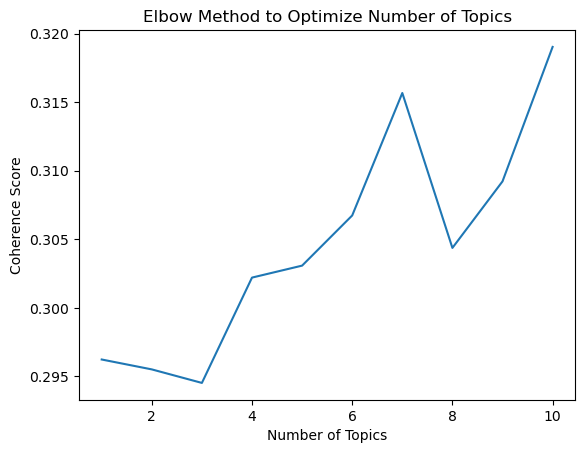

In [87]:
from gensim.models.coherencemodel import CoherenceModel

# Find the optimal number of topics using the Elbow Method
coherence_values = []
for num_topics in range(1, 11):
    ldamodel = gensim.models.LdaMulticore(reddit_suicidal_bow_corpus, num_topics=num_topics, id2word=reddit_suicidal_dic, passes=2, workers=2)
    cm = CoherenceModel(model=ldamodel, texts=reddit_corpus_tokenized, dictionary=reddit_suicidal_dic, coherence='c_v')
    coherence_values.append(cm.get_coherence())

# Plot the coherence values
plt.plot(range(1, 11), coherence_values)
plt.xlabel('Number of Topics')
plt.ylabel('Coherence Score')
plt.title('Elbow Method to Optimize Number of Topics')

In [88]:
# Select the model with the highest coherence score and print the topics
best_result_index = coherence_values.index(max(coherence_values))
optimal_model = gensim.models.LdaMulticore(reddit_suicidal_bow_corpus, num_topics=best_result_index+2, id2word=reddit_suicidal_dic, passes=2, workers=2)
model_topics = optimal_model.show_topics(formatted=False)
print(f'The {best_result_index+2} topics gives the highest coherence score of {coherence_values[best_result_index]}')

The 11 topics gives the highest coherence score of 0.3190297302317796


In [89]:
from gensim.models.ldamodel import LdaModel

def convertldaGenToldaMallet(mallet_model):
    model_gensim = LdaModel(
        id2word = mallet_model.id2word, num_topics = mallet_model.num_topics,
        alpha = mallet_model.alpha, eta=0,
    )
    model_gensim.state.sstats[...] = mallet_model.state.sstats
    model_gensim.sync_state()
    return model_gensim

optimal_model = convertldaGenToldaMallet(optimal_model)

# Creating Topic Distance Visualization 
pyLDAvis.enable_notebook()
p = gensimvis.prepare(optimal_model, reddit_suicidal_bow_corpus, reddit_suicidal_dic)
p

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2      0.042744 -0.021246       1        1  15.137674
4      0.022609 -0.053508       2        1  13.830106
1     -0.098341 -0.001131       3        1  10.722685
9     -0.053764  0.029304       4        1   9.917726
5      0.105885  0.054415       5        1   9.726375
10    -0.058076  0.070358       6        1   8.714433
3     -0.007147  0.119111       7        1   7.903985
0     -0.038761 -0.032257       8        1   6.687336
6      0.151326 -0.046289       9        1   6.345978
7      0.019810 -0.016348      10        1   6.148195
8     -0.086285 -0.102407      11        1   4.865505, topic_info=       Term           Freq          Total Category  logprob  loglift
434    fuck   65003.000000   65003.000000  Default  30.0000  30.0000
12     feel  151365.000000  151365.000000  Default  29.0000  29.0000
45     want  171835.000000  171835.000000  Default  28.0000  28.0000
37   suicid   59571.000000   59571.000000  Default  27.0000  27.0000
13      get  122978.000000  122978.000000  Default  26.0000  26.0000
..      ...            ...            ...      ...      ...      ...
470    live    2523.709743   64609.120207  Topic11  -5.2970  -0.2196
280     one    2455.948148   74308.771692  Topic11  -5.3242  -0.3867
755    sinc    2182.901124   26747.955721  Topic11  -5.4421   0.5172
171    time    2280.371223   87364.811205  Topic11  -5.3984  -0.6228
45     want    2289.487383  171835.547481  Topic11  -5.3944  -1.2952

[1419 rows x 6 columns], token_table=       Topic      Freq     Term
term                           
13831      2  0.999957   abject
6402      10  1.009413   abouti
20133     11  1.006875  abstain
1457       1  0.021102     abus
1457       2  0.014834     abus
...      ...       ...      ...
1647       8  0.759616   youtub
1647       9  0.004670   youtub
1647      10  0.001557   youtub
1647      11  0.018679   youtub
2956       8  0.994958  zealand

[4957 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 5, 2, 10, 6, 11, 4, 1, 7, 8, 9])

In [90]:
twitter_corpus = suicidal_twitter.loc[suicidal_twitter['Suicide'] == 1, 'Tweet']
twitter_corpus_tokenized = [gensim.utils.simple_preprocess(doc) for doc in twitter_corpus]
twitter_suicidal_dic = gensim.corpora.Dictionary(twitter_corpus_tokenized)
twitter_suicidal_bow_corpus = [twitter_suicidal_dic.doc2bow(doc) for doc in twitter_corpus_tokenized]
twitter_lda_model = gensim.models.LdaMulticore(twitter_suicidal_bow_corpus,
                                               num_topics=4,
                                               id2word=twitter_suicidal_dic,
                                               passes=2,
                                               workers=2)


for idx, topic in twitter_lda_model.print_topics(-1):
    print(f'Topic: {idx} \nWords: {topic}\n')

Topic: 0 
Words: 0.017*"feel" + 0.015*"like" + 0.014*"know" + 0.013*"go" + 0.011*"get" + 0.010*"life" + 0.009*"want" + 0.009*"time" + 0.008*"even" + 0.008*"suicid"

Topic: 1 
Words: 0.016*"want" + 0.012*"know" + 0.012*"feel" + 0.010*"go" + 0.010*"like" + 0.009*"get" + 0.009*"life" + 0.009*"time" + 0.008*"even" + 0.008*"realli"

Topic: 2 
Words: 0.012*"go" + 0.012*"know" + 0.011*"want" + 0.010*"like" + 0.010*"feel" + 0.008*"life" + 0.008*"get" + 0.007*"one" + 0.007*"hate" + 0.007*"depress"

Topic: 3 
Words: 0.033*"want" + 0.013*"feel" + 0.012*"life" + 0.011*"die" + 0.011*"get" + 0.011*"like" + 0.009*"would" + 0.008*"one" + 0.008*"go" + 0.008*"fuck"



In [91]:
pyLDAvis.enable_notebook()
twitter_vis = gensimvis.prepare(twitter_lda_model, twitter_suicidal_bow_corpus, twitter_suicidal_dic)
twitter_vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0     -0.005994  0.015030       1        1  43.545815
3     -0.011106 -0.015281       2        1  29.286510
1     -0.003113  0.003630       3        1  17.612404
2      0.020213 -0.003380       4        1   9.555271, topic_info=       Term         Freq        Total Category  logprob  loglift
51     want  5093.000000  5093.000000  Default  30.0000  30.0000
123    know  3255.000000  3255.000000  Default  29.0000  29.0000
3        go  3101.000000  3101.000000  Default  28.0000  28.0000
17      die  1728.000000  1728.000000  Default  27.0000  27.0000
19     hate   996.000000   996.000000  Default  26.0000  26.0000
..      ...          ...          ...      ...      ...      ...
203  friend   149.000098  2072.440129   Topic4  -5.2240  -0.2845
80   realli   136.448687  1721.456098   Topic4  -5.3120  -0.1869
1       day   127.059591  1565.456320   Topic4  -5.3833  -0.1632
230    even   136.116177  2050.464685   Topic4  -5.3145  -0.3642
53     kill   112.035313  1722.844589   Topic4  -5.5091  -0.3848

[355 rows x 6 columns], token_table=       Topic      Freq    Term
term                          
14382      2  0.803228  aaahhh
327        4  0.801306     aai
2144       1  0.114346  accord
2144       2  0.114346  accord
2144       3  0.571730  accord
...      ...       ...     ...
14343      3  0.627607     wud
432        1  0.470062    year
432        2  0.270642    year
432        3  0.168388    year
432        4  0.091571    year

[592 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 4, 2, 3])

<div class="alert alert-block alert-info">
<b>Separate file for complex tasks:</b> The feature extraction, modeling and evaluation will be divided into separate .ipynb file for better organization and modularity.
</div>

In [95]:
suicidal_twitter = pd.read_csv('twitter_cleaned_stemmed.csv', index_col=0)
suicidal_reddit = pd.read_csv('reddit_cleaned_stemmed.csv', index_col=0)
# index_col=False dunno why mine not working (xinyi)
suicidal_twitter

,Tweet,Suicide
0,make lunch,0
1,want money,0
2,crap took forev put togeth iam go go sleep day,1
3,hey jer sinc start twitter,0
4,tri delici librari mix result bar code thought...,0
...,...,...
9114,ever laid bed night cri good enough count flaw...,1
9115,fault blame pain still alon insid broken home ...,1
9116,stop ask trust still cough water last time let...,1
9117,never know handl sad cri make feel stupid,1
